<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/adaptive_cov/mcmc/run_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee

#Running all the other notebooks to load them in
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/mcmc_algorithm.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/adaptive_sampling_mcmc.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/convergence_diagnostics.ipynb'

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

supernova_df.head()

,CID,Z,c,cerr,x1,x1err,x0,x0err,mb,mberr,MU,MUERR,covx0x1,covx0c,covx1c
0,90O,0.0306,-0.0615,0.0324,0.3063,0.3943,0.005963,0.000209,16.210047,0.038083,35.547001,0.106,0.000010,-0.000005,-0.003592
1,93B,0.0707,0.0594,0.0376,-0.6927,0.3300,0.000736,0.000035,18.469965,0.051633,37.396999,0.120,0.000001,-0.000001,-0.001280
2,92P,0.0263,-0.0777,0.0287,0.1607,0.4422,0.006898,0.000143,16.053383,0.022515,35.415001,0.097,-0.000016,-0.000003,-0.001496
3,93H,0.0248,0.1963,0.0412,-2.8668,0.2425,0.003563,0.000169,16.743837,0.051566,35.095001,0.139,0.000007,-0.000006,-0.002212
4,93O,0.0519,-0.0666,0.0271,-0.9641,0.2376,0.001618,0.000035,17.626810,0.023160,36.840000,0.086,-0.000004,-0.000001,0.000531


In [ ]:
#For each MCMC algorithm use 10,000 iterations, 10 walkers, 20% burn in, and step size 0.005

#Starting for the basic mcmc algortihm as a baseline
np.random.seed(69)
num_walkers = 10

#10 initial guesses in the ranges of 0.2<omega_m<0.4 and 0.6<h<0.8
initial_guess = [[np.random.uniform(0.2,0.4), np.random.uniform(0.6,0.8)]
                for _ in range(num_walkers)]

n_steps = 10000
step_size = [0.01,0.01]




In [ ]:
#Basic MCMC algorithm with 10k iterations, 0.005 step size 20% burn in and 10 walkers
%time basicmc_samples = metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, n_steps, initial_guess, step_size, 0.2, 10)


MCMC carried out with 10000 steps, and acceptance ratio of each walker [0.2395 0.2428 0.2383 0.2419 0.2401 0.2406 0.2413 0.2419 0.2369 0.236 ]
CPU times: user 5min 54s, sys: 2.28 s, total: 5min 56s
Wall time: 5min 59s


In [ ]:
#GR diagnostic and ess

#get omega m and h as 2d arrays
omega_basic_samples = basicmc_samples[:,:,0]
h_basic_samples = basicmc_samples[:,:,1]

gr_omega_basic = gelman_rubin(omega_basic_samples)
gr_h_basic = gelman_rubin(h_basic_samples)

ess_omega_basic = eff_sample_size_multichain(omega_basic_samples)
ess_h_basic = eff_sample_size_multichain(h_basic_samples)

print(f'Gelman Rubin Diagnostic for Omega_m: {gr_omega_basic}')
print(f'Gelman Rubin Diagnostic for h: {gr_h_basic}')


#Effective sample size
print(f'Effective sample size for Omega m: {ess_omega_basic}')
print(f'Effective sample size for h: {ess_h_basic}')


Gelman Rubin Diagnostic for Omega_m: 1.0070798282778683
Gelman Rubin Diagnostic for h: 1.0037422330073924
Effective sample size for Omega m: 674.5075514932478
Effective sample size for h: 1449.337084951678


# Adaptive sampling pilot runs
Some pilot runs of my adaptive sampling algorithm to find out which parameters are the best to use.
Experimented with using different update intervals, target acceptance rates and learning rates of the algorithm.
Did this with 2000 iterations just to see what differences there are before implementing my full adaptive sampling algorithm with the 'best' parameters to use for 10,000 iterations.

Labelled these test cases A,B,C,D,E,F

Then I checked each pilot run using my GR diagnostic and ESS to determine what has the best number of effective samples and converges.

In [ ]:
#some pilot runs of adaptive mcmc to see which is good to use

A_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.1)
B_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.3, 0.1)
C_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.2)
D_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.2)
E_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.3, 0.2)
F_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 150, 0.25, 0.15)
G_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.3)
H_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.4)
I_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.5)
J_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 1)
K_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.01)
L_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 10)
M_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 200, 0.25, 0.001)
N_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.4)
O_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 300, 0.25, 0.4)
P_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.01)
Q_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.1)
R_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.3)
S_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.2)
T_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.1)
U_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.05)
V_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.01)
W_adaptive_samples = adaptive_metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, 2000, initial_guess, step_size, 0.2, 10, 100, 0.25, 0.005)

# Plots of Effective sample size of each pilot run

In [ ]:
#Making sure all the chains have converged if there GR roughly = 1
# List of trial labels
trial_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']

# Dictionary to store results for each trial
gelman_results = {}

# Loop through each trial
for trial in trial_names:
    # Get the chain variable from the global namespace
    # This assumes your chains are stored as variables like A_adaptive_samples, B_adaptive_samples, etc.
    chain = globals()[f"{trial}_adaptive_samples"]

    gr_omega = gelman_rubin(chain[:,:,0])
    gr_h = gelman_rubin(chain[:,:,1])

    # store in dictionary
    gelman_results[trial] = {'Omega_m': gr_omega, 'h': gr_h}

    # Print the results
    print(f"Gelman Rubin Diagnostic for trial {trial}: Omega_m = {gr_omega}, h = {gr_h}")


Gelman Rubin Diagnostic for trial A: Omega_m = 1.012060583944152, h = 1.010566417404697
Gelman Rubin Diagnostic for trial B: Omega_m = 1.0092729495333768, h = 1.0051472773961745
Gelman Rubin Diagnostic for trial C: Omega_m = 1.0085156538184161, h = 1.007977587707998
Gelman Rubin Diagnostic for trial D: Omega_m = 1.0109252254152024, h = 1.0047214581104653
Gelman Rubin Diagnostic for trial E: Omega_m = 1.006004478172438, h = 1.0058158357137337
Gelman Rubin Diagnostic for trial F: Omega_m = 1.0090871270317785, h = 1.004917939134264
Gelman Rubin Diagnostic for trial G: Omega_m = 1.0083355466037525, h = 1.0047168705339984
Gelman Rubin Diagnostic for trial H: Omega_m = 1.0045222842211752, h = 1.0035119462602817
Gelman Rubin Diagnostic for trial I: Omega_m = 1.0106520598177997, h = 1.006913179799929
Gelman Rubin Diagnostic for trial J: Omega_m = 1.0099340033411333, h = 1.008071739801755
Gelman Rubin Diagnostic for trial K: Omega_m = 1.0244950159185786, h = 1.0094604383601125
Gelman Rubin Diag

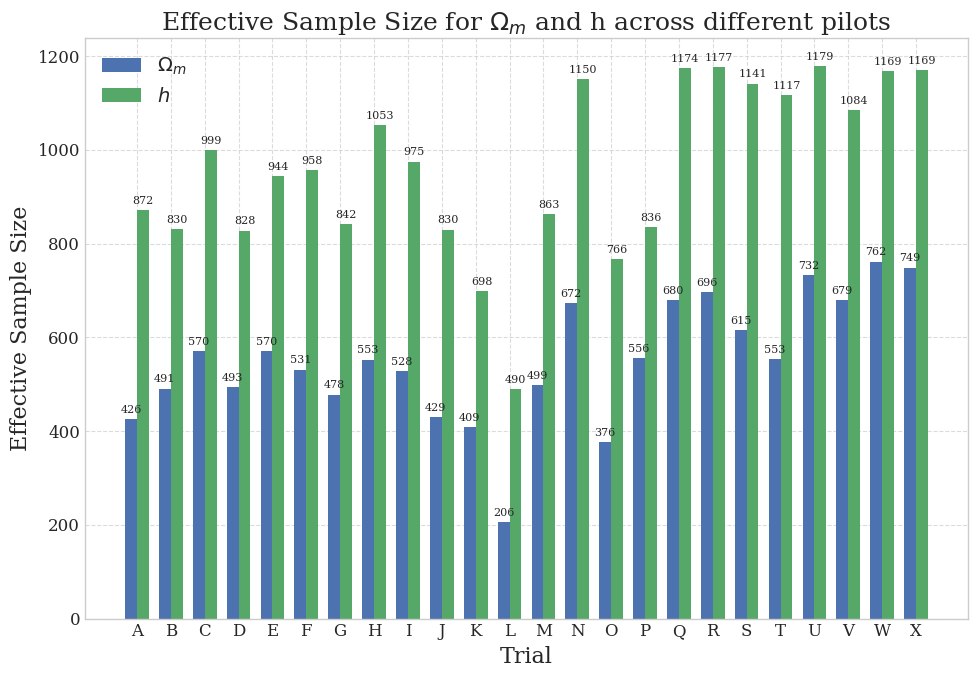

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use a clean, white grid s

plt.style.use('seaborn-v0_8-whitegrid')
# Update rcParams for a scientific look (serif fonts, larger sizes)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

# List of trial labels
trials = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']

# Initialize lists to store ESS values for each parameter
ess_omega = []
ess_h = []

# Loop over each trial and compute ESS for Omega_m (parameter index 0) and h (index 1)
for trial in trials:
    chain = globals()[f"{trial}_adaptive_samples"]
    ess_omega.append(eff_sample_size_multichain(chain[:,:,0]))
    ess_h.append(eff_sample_size_multichain(chain[:,:,1]))

# Set up positions and bar width for a grouped bar chart
x = np.arange(len(trials))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
bars_omega = ax.bar(x - width/2, ess_omega, width, label="$\Omega_{m}$", color="#4C72B0")
bars_h     = ax.bar(x + width/2, ess_h, width, label="$h$", color="#55A868")

# Function to add numerical labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Vertical offset in points
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8 )

add_labels(bars_omega)
add_labels(bars_h)

#Label all the shit
ax.set_xlabel("Trial", fontsize=16)
ax.set_ylabel("Effective Sample Size", fontsize=16)
ax.set_title("Effective Sample Size for $\Omega_{m}$ and h across different pilots", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(trials)
ax.legend(frameon=False)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
